<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Labraries 
             </p> </div>

In [100]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from tensorflow.keras.applications import VGG16
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture




<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Get the Data
             </p> </div>

In [54]:
# Define paths to the directories
annotations_dir = r"C:\Users\User\OneDrive - Centennial College\Desktop\FaceMaskDetection_DeepLearning\annotations"
images_dir = r"C:\Users\User\OneDrive - Centennial College\Desktop\FaceMaskDetection_DeepLearning\images"

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
   Exploration
             </p> </div>

In [55]:

# Function to list files in a directory
def list_files(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

# List files in annotations and images directories
annotations_files = list_files(annotations_dir)
images_files = list_files(images_dir)

# Print the first few files to understand the format
print("Annotations files:", annotations_files[:2])
print("Images files:", images_files[:2])

Annotations files: ['C:\\Users\\User\\OneDrive - Centennial College\\Desktop\\FaceMaskDetection_DeepLearning\\annotations\\maksssksksss0.xml', 'C:\\Users\\User\\OneDrive - Centennial College\\Desktop\\FaceMaskDetection_DeepLearning\\annotations\\maksssksksss1.xml']
Images files: ['C:\\Users\\User\\OneDrive - Centennial College\\Desktop\\FaceMaskDetection_DeepLearning\\images\\maksssksksss0.png', 'C:\\Users\\User\\OneDrive - Centennial College\\Desktop\\FaceMaskDetection_DeepLearning\\images\\maksssksksss1.png']


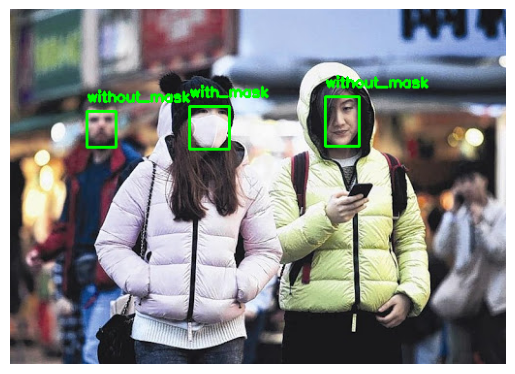

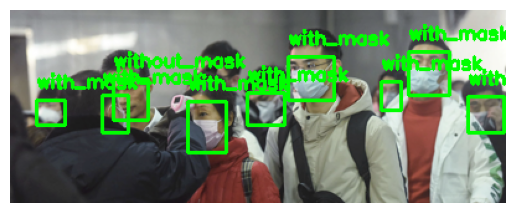

In [56]:
# Function to display image with annotations
def display_image_with_annotations(image_path, annotation_path):
    image = cv2.imread(image_path)
    
    # Parse XML annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        # Draw rectangle
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display a few images with annotations for exploration
for i in range(2):  # Displaying only two images for illustration
    display_image_with_annotations(images_files[i], annotations_files[i])


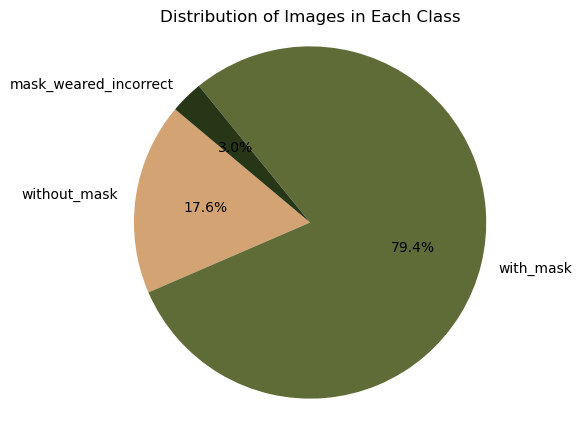

In [57]:
# Dictionary to store the count of images in each class
class_counts = {}

# Loop through the annotation files to count the images in each class
for annotation_file in annotations_files:
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        # Increment the count for the current class
        class_counts[label] = class_counts.get(label, 0) + 1

# Extract class labels and counts for pie chart
labels = list(class_counts.keys())
counts = list(class_counts.values())
# Define custom colors
custom_colors = ['#d4a373', '#606c38', '#283618', '#ffcc99', '#c2c2f0']

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Distribution of Images in Each Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()






<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
   Preparing the Data for Feature Extraction with VGG16
             </p> </div>

In [87]:
# Function to preprocess images for VGG16
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        image = preprocess_input(image)
        images.append(image)
    return np.array(images)

# Preprocess images
preprocessed_images = preprocess_images(images_files)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Pre-trained VGG16 model
             </p> </div>

In [59]:
# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from preprocessed images
features = vgg_model.predict(preprocessed_images)

# Flatten the features
features_flattened = features.reshape(features.shape[0], -1)

27/27 [==============================] - 2817s 103s/step


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    PCA
             </p> </div>

In [88]:
# Function to visualize clusters
def visualize_clusters(features_flattened, cluster_labels, num_clusters):
    # Perform dimensionality reduction for visualization (e.g., PCA or t-SNE)
    # You can replace this with your preferred dimensionality reduction technique
    from sklearn.decomposition import PCA
    pca = PCA(n_components=100)
    features_pca  = pca.fit_transform(features_flattened)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Clustering Algorithms
             </p> </div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    K-means clustering
             </p> </div>

In [108]:
# Apply K-means clustering to the extracted features
kmeans_clustering  = KMeans(n_clusters=3, random_state=42)
cluster_labels_km = kmeans_clustering .fit_predict(features_pca)

# Evaluate clustering using silhouette score
silhouette_score_km = silhouette_score(features_pca, cluster_labels_km)
print(f'Silhouette Score (K-means): {silhouette_score_km}')

c:\Users\User\newConda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score (K-means): 0.07716971635818481


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Hierarchical Clustering
             </p> </div>

In [106]:

# Initialize the hierarchical clustering model
# You can adjust parameters such as linkage and distance metric as needed
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

# Fit the model to the extracted features
hierarchical_clustering.fit(features_pca)

# Get the cluster labels assigned to each data point
cluster_labels_hc = hierarchical_clustering.labels_

# Calculate the silhouette score to evaluate the clustering performance
silhouette_score_hc = silhouette_score(features_pca, cluster_labels_hc)
print("Silhouette Score (Hierarchical Cluster):", silhouette_score_hc)


c:\Users\User\newConda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score (Hierarchical Cluster): 0.114805415


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
GMM             </p> </div>

In [115]:
# Initialize the Gaussian Mixture Models clustering model
gmm_clustering = GaussianMixture(n_components=3, random_state=42)

# Fit the model to the reduced features
gmm_clustering.fit(features_pca)

# Get the cluster labels assigned to each data point
cluster_labels_gmm = gmm_clustering.predict(features_pca)

# Calculate the silhouette score for Gaussian Mixture Models clustering
silhouette_score_gmm = silhouette_score(features_pca, cluster_labels_gmm)
print("Silhouette Score (Gaussian Mixture Models):", silhouette_score_gmm)


Silhouette Score (Gaussian Mixture Models): 0.08095675


The Silhouette Score is a metric used to evaluate the quality of clusters in unsupervised learning. It quantifies how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The Silhouette Score ranges from -1 to 1, where:

A score close to +1 indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. This suggests that the clustering configuration is appropriate.
A score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.
A score close to -1 indicates that the object may have been assigned to the wrong cluster.

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Cluster Visualization
             </p> </div>

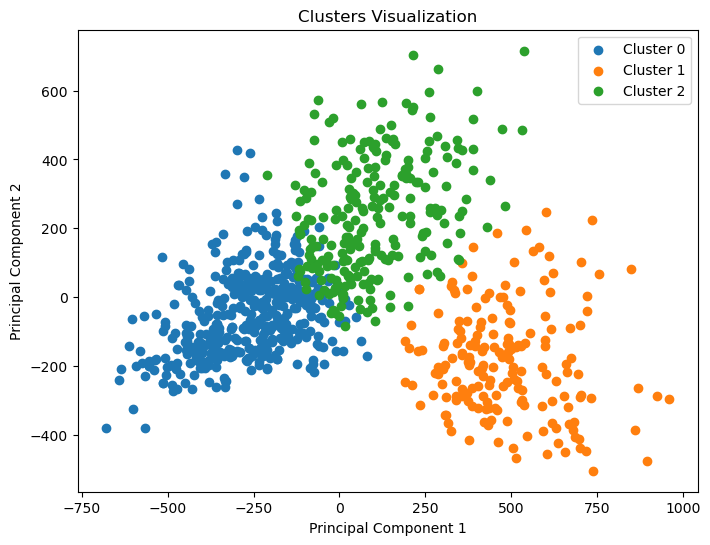

In [116]:
def visualize_clusters(features, cluster_labels, num_clusters):
    plt.figure(figsize=(8, 6))
    for i in range(num_clusters):
        cluster_points = features[cluster_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
    plt.title('Clusters Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Visualize clusters
visualize_clusters(features_pca, cluster_labels_gmm, num_clusters)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#606c38;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    Evaluation
             </p> </div>

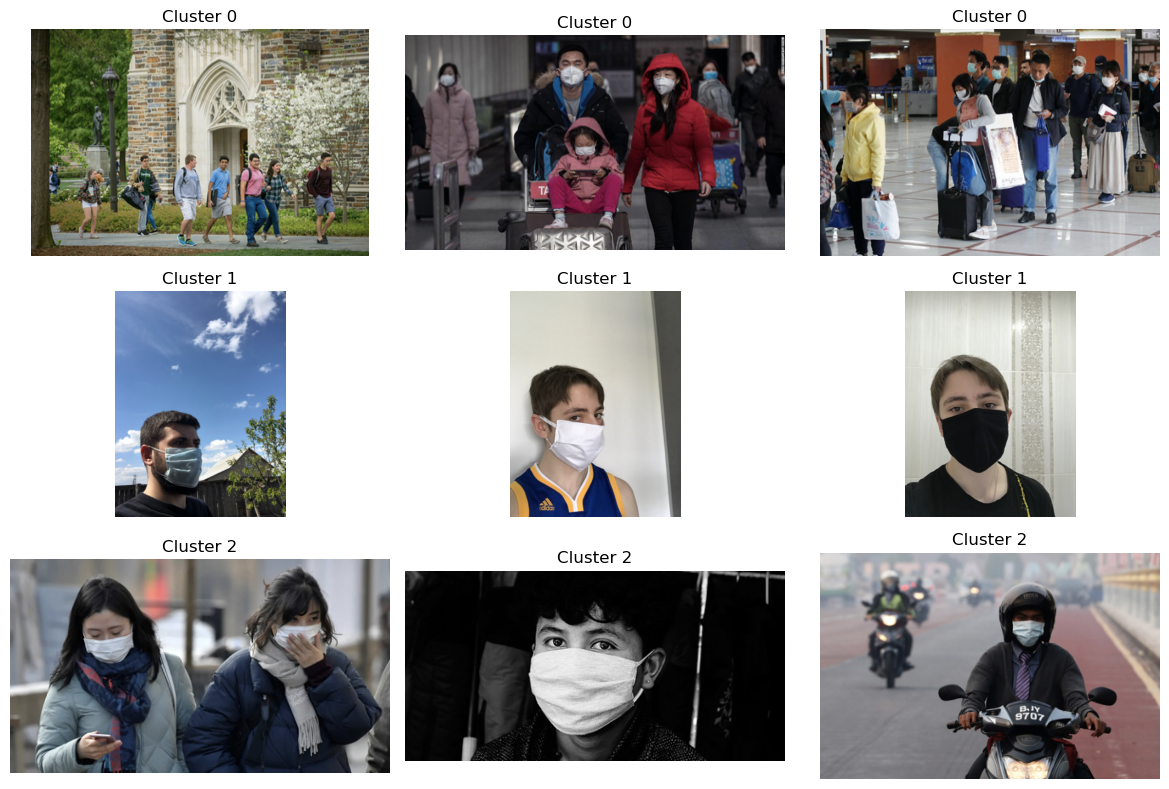

In [119]:
def visualize_cluster_images(images_files, cluster_labels, num_clusters, num_images_per_cluster=3):
    plt.figure(figsize=(12, 8))
    for cluster in range(num_clusters):
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        random_indices = random.sample(cluster_indices, min(num_images_per_cluster, len(cluster_indices)))
        for i, idx in enumerate(random_indices):
            image = cv2.imread(images_files[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.subplot(num_clusters, num_images_per_cluster, cluster * num_images_per_cluster + i + 1)
            plt.imshow(image)
            plt.title(f'Cluster {cluster}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images from each cluster using hierarchical clustering labels
visualize_cluster_images(images_files, cluster_labels_gmm, num_clusters)


Gonna finish it tomorrow 